In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
EPS = 1e-6

class VNLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(VNLinear, self).__init__()
        self.map_to_feat = nn.Linear(in_features, out_features, bias=False)
    
    def forward(self, x):
        '''
        x: point features of shape [B, N_feat, 3, N_samples, ...]
        '''
        x_out = self.map_to_feat(x.transpose(1,-1)).transpose(1,-1)
        return x_out


class VNReLU(nn.Module):
    def __init__(self, in_features, negative_slope=0.2):
        super(VNReLU, self).__init__()
        self.map_to_dir = nn.Linear(in_features, in_features, bias=False)
        self.negative_slope = negative_slope
    
    def forward(self, x):
        '''
        x: point features of shape [B, N_feat, 3, N_samples, ...]
        '''
        d = self.map_to_dir(x.transpose(1,-1)).transpose(1,-1)
        dotprod = (x*d).sum(2, keepdim=True)
        mask = (dotprod >= 0).float()
        d_norm_sq = (d*d).sum(2, keepdim=True)
        x_out = self.negative_slope * x + (1-self.negative_slope) * (mask*x + (1-mask)*(x-(dotprod/(d_norm_sq+EPS))*d))
        return x_out


class VNBatchNorm(nn.Module):
    def __init__(self, num_features):
        super(VNBatchNorm, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)
    
    def forward(self, x):
        '''
        x: point features of shape [B, N_feat, 3, N_samples, ...]
        '''
        norm = torch.norm(x, dim=2) + EPS
        norm_bn = self.bn(norm)
        norm = norm.unsqueeze(2)
        norm_bn = norm_bn.unsqueeze(2)
        x = x / norm * norm_bn
        return x
    

class VNInvariantFeature(nn.Module):
    def __init__(self, feature_dim, negative_slope=0.2):
        super(VNInvariantFeature, self).__init__()
        self.vn_layer_1 = nn.Sequential(
            VNLinear(feature_dim, feature_dim//2),
            VNBatchNorm(feature_dim//2),
            VNReLU(feature_dim//2, negative_slope))
        self.vn_layer_2 = nn.Sequential(
            VNLinear(feature_dim//2, feature_dim//4),
            VNBatchNorm(feature_dim//4),
            VNReLU(feature_dim//4, negative_slope))
        self.vn_lin = nn.Linear(feature_dim//4, 3, bias=False)
    
    def forward(self, x):
        '''
        x: point features of shape [B, N_feat, 3, N_samples, ...]
        '''
        x_equ = self.vn_layer_1(x)
        x_equ = self.vn_layer_2(x_equ)
        x_equ = self.vn_lin(x_equ.transpose(1, -1)).transpose(1, -1)
        x_equ = x_equ.transpose(1, 2)
        x_inv = torch.einsum('bijm,bjkm->bikm', x, x_equ)
        return x_inv

In [3]:
class Encoder(nn.Module):
    def __init__(self, in_dim, negative_slope=0.0):
        super(Encoder, self).__init__()
        self.sn_layer = nn.Sequential(
            nn.Linear(in_dim, 3*3*128), # or nn.Linear(in_dim, 3*3) then unsqueeze
            nn.BatchNorm1d(3*3*128),
            nn.ReLU())
        self.vn_layer_1 = nn.Sequential(
            VNLinear(128, 64),
            VNBatchNorm(64),
            VNReLU(64, negative_slope))
        self.vn_layer_2 = nn.Sequential(
            VNLinear(64, 32),
            VNBatchNorm(32),
            VNReLU(32, negative_slope))
        self.std_feature = VNInvariantFeature(32*2, negative_slope)
        self.vn_linear = VNLinear(32*2, 1)
        
    def forward(self, x):
        x = self.sn_layer(x)
        
        # reshape to [B, N_feat, 3, N_samples]
        # N_samples=3 for 3 primitive lattice vectors a,b,c
        B, D, N = x.shape[0], 3, 3
        x = x.view(B, 128, D, N)
        
        # SO(3) equivariant vector network 
        x = self.vn_layer_1(x)
        x = self.vn_layer_2(x)
        
        # SO(3) invariant features (sec 3.5 paper)
        x_mean = x.mean(dim=-1, keepdim=True).expand(x.size())
        x = torch.cat((x, x_mean), 1)
        x = self.std_feature(x)
        
        x = self.vn_linear(x)
        x = x.squeeze(1)
        return x

    
def test():
    x = torch.randn((100, 1000))
    model = Encoder(1000)
    x_hat = model(x)
    print(x_hat.shape)
test()

torch.Size([100, 3, 3])


In [6]:
rootdir = './material.pkl'

id = []
xrd = np.empty([41100,1000])
params = np.empty([41100,6])

with open(rootdir, 'rb') as f:
    material = pickle.load(f)
    for i, k in enumerate(material.keys()):
        id.append(k)
        xrd[i] = np.array(material[k]['xrd'])[0]
        params[i] = np.array(material[k]['param'])

In [7]:
def get_lattice_vectors(a, b, c, alpha, beta, gamma):
    '''http://gisaxs.com/index.php/Unit_cell'''
    
    alpha = np.radians(alpha)
    beta = np.radians(beta)
    gamma = np.radians(gamma)
    
    # a 
    a1 = a
    a2 = 0
    a3 = 0
    
    # b
    b1 = b * np.cos(gamma)
    b2 = b * np.sin(gamma)
    b3 = 0
    
    # c
    c1 = c * np.cos(beta)
    c2 = c * (np.cos(alpha) - np.cos(beta)*np.cos(gamma)) / np.sin(gamma)
    c3 = c * np.sqrt(1 - np.cos(beta)**2 - ((np.cos(alpha) - np.cos(beta)*np.cos(gamma)) / np.sin(gamma))**2)

    a_ = np.array([a1, a2, a3])
    b_ = np.array([b1, b2, b3])
    c_ = np.array([c1, c2, c3])
    
    return a_, b_, c_

In [8]:
abc = np.empty([41100,3,3])

for i, param in enumerate(params):
    a, b, c = get_lattice_vectors(
        param[0], 
        param[1],
        param[2],
        param[3],
        param[4],
        param[5])
    
    abc[i][:,0] = a
    abc[i][:,1] = b
    abc[i][:,2] = c

In [9]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(Dataset, self).__init__()
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.X[idx], self.y[idx]
    
    
X, y = xrd, abc
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
dataset = Dataset(X, y)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024)
dataloaders = {'Train': trainloader, 'Val': testloader}

In [10]:
def mse(y, y_pred):
    return nn.MSELoss(reduction='mean')(y, y_pred)

In [11]:
model = Encoder(in_dim=1000)

train_loss_list = []
test_loss_list = []

for epoch in range(1, 40 + 1):

    # split epochs into training and validation phase
    for phase in ['Train', 'Val']:
        if phase == 'Train':
            optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
            model.train(True)
        else:
            model.train(False)

        # mini batch training
        train_loss = 0
        test_loss = 0
        for batch, (X, y) in enumerate(dataloaders[phase]):
            optimizer.zero_grad()

            X, y = X.float(), y.float()
            
            # forward propagation
            y_pred = model(X) 
            
            loss = mse(y, y_pred)
            train_loss += loss.item()
            test_loss += loss.item()

            # optimization step only in training phase
            if phase == 'Train':
                loss.backward()
                optimizer.step()

                # print progress
                if batch == len(trainloader) - 1:
                    print('Epoch: {}, Train Loss: {:.3f}'.format(
                        epoch,
                        train_loss / len(trainloader)))
                    train_loss_list.append(train_loss / len(trainloader))
                    train_loss = 0
            
            else:
                if batch == len(testloader) - 1:
                    print('Epoch: {}, Test Loss: {:.3f}'.format(
                        epoch,
                        test_loss / len(testloader)))
                    test_loss_list.append(test_loss / len(testloader))
                    test_loss = 0

Epoch: 1, Train Loss: 28.199
Epoch: 1, Test Loss: 29.324
Epoch: 2, Train Loss: 26.749
Epoch: 2, Test Loss: 26.248
Epoch: 3, Train Loss: 21.422
Epoch: 3, Test Loss: 23.180
Epoch: 4, Train Loss: 14.245
Epoch: 4, Test Loss: 13.922
Epoch: 5, Train Loss: 9.989
Epoch: 5, Test Loss: 8.942
Epoch: 6, Train Loss: 8.119
Epoch: 6, Test Loss: 10.321
Epoch: 7, Train Loss: 7.425
Epoch: 7, Test Loss: 7.045
Epoch: 8, Train Loss: 6.906
Epoch: 8, Test Loss: 6.686
Epoch: 9, Train Loss: 6.722
Epoch: 9, Test Loss: 7.470
Epoch: 10, Train Loss: 6.527
Epoch: 10, Test Loss: 6.429
Epoch: 11, Train Loss: 6.369
Epoch: 11, Test Loss: 5.995
Epoch: 12, Train Loss: 6.166
Epoch: 12, Test Loss: 6.610
Epoch: 13, Train Loss: 6.080
Epoch: 13, Test Loss: 7.832
Epoch: 14, Train Loss: 5.946
Epoch: 14, Test Loss: 5.931
Epoch: 15, Train Loss: 5.792
Epoch: 15, Test Loss: 6.505
Epoch: 16, Train Loss: 5.873
Epoch: 16, Test Loss: 6.015
Epoch: 17, Train Loss: 5.444
Epoch: 17, Test Loss: 5.714
Epoch: 18, Train Loss: 5.416
Epoch: 18, 

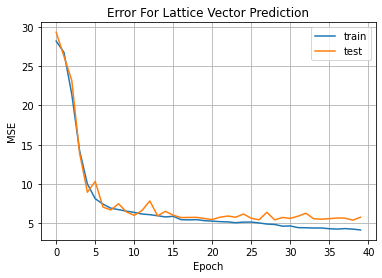

In [12]:
# plot average MSE over all iterations
plt.title("Error For Lattice Vector Prediction")
plt.plot(train_loss_list, label='train')
plt.plot(test_loss_list, label='test')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid()
plt.legend()